# Hot Project Machine Learning Model

###  This model reflects manual process for comming up witn an effective model for a classificaiton Project



In [15]:
# import dependencies needed to build our model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sqlalchemy import create_engine
import sqlite3 
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, plot_roc_curve
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
import tqdm

## EVALUATE FUNCTION

Since we will be trying lots of different models, we built a single function that will evaluate all our models and provide a standardized reporting format.

This will allow us to easily pick out the best model we want to move forward with.

This function takes in a model ( pipeline ) and our train test split data. From there it simply performes predictions and generates results

In [2]:
def evaluate(pipeline, X_train, X_test, y_train, y_test):
    '''
    Evaluate a pipeline on training and test datasets
    '''    
    pipeline.fit(X_train, y_train)
    y_train_hat = pipeline.predict(X_train)
    y_test_hat = pipeline.predict(X_test)
    train_f1 = f1_score(y_train_hat, y_train)
    train_acc = accuracy_score(y_train_hat, y_train)
    test_f1 = f1_score(y_test_hat, y_test)
    test_acc = accuracy_score(y_test_hat, y_test)

    print(f"========== Predictor: {type(pipeline).__name__} ==========")
    print(f"Training result: f1: {train_f1:.3f}, acc: {train_acc:.3f}")
    print(f"Test result: f1: {test_f1:.3f}, acc: {test_acc:.3f}")
    print()


## DATA
In this case we are reading in top 200 hot and not hot people data.  With this data we are trying to predict if an individual is hot or not based on specific features.

#### The features are:
- Sex  ->   Male or Female.
- Age -> How old is an indiviual.
- Eye Color -> Variation of eyes colors.
- Hair Color -> Different hair colors effect looks.
- Distinctive Features -> Mainly related to how an individual look like.
- Height -> How tall are they.
- Weight -> Body mass effect looks.
- Zodiac Sign -> Is your star lucky.
- Tattoo Body Art -> Do they have any inks in their body.

In [3]:
# load dataset from sqlite dataBase. Creat an engine and then use pandas to read and convert the sql table into dataframe

engine = create_engine('sqlite:///../dataBase/Are_You_Hot.db')
hot_df = pd.read_sql('select * from hot', engine)
hot_df.head(10)

,Name,Sex,DOB,Birth Year,Eye Color,Hair Color,Distinctive Features,Height(ft),Weight(lbs),Zodiac Sign,Tattoo Body Art,Hot Test,Ht/Wt Ratio,Age
0,Angelina Jolie,Female,06/04/1975,1975,Gray,Blonde,Lips,5.50,119.0,Gemini,Yes,0,21.64,45
1,Johnny Depp,Male,06/09/1963,1963,Brown,Brown,Cheekbones,5.83,171.0,Gemini,Yes,0,29.33,57
2,Charlize Theron,Female,08/07/1975,1975,Green,Brown,Attractive,5.75,121.0,Leo,Yes,0,21.04,45
3,Brad Pitt,Male,12/18/1963,1963,Blue,Blonde,Jaw,5.91,172.0,Sagittarius,Yes,0,29.10,57
4,Amber Heard,Female,04/22/1986,1986,Blue,Blonde,Body,5.58,137.0,Taurus,Yes,0,24.55,34
5,Jared Leto,Male,12/26/1971,1971,Blue,Brown,Eyes,5.75,152.0,Capricorn,Yes,0,26.43,49
6,Natalie Portman,Female,06/09/1981,1981,Hazel,Brown,Moles,5.25,110.0,Gemini,No,0,20.95,39
7,Channing Tatum,Male,04/26/1980,1980,Green,Brown,Eyes,6.08,196.0,Taurus,Yes,0,32.24,40
8,Mila Kunis,Female,08/14/1983,1983,Green and Blue,Brown,Body,5.33,115.0,Leo,No,0,21.58,37
9,Chris Hemsworth,Male,08/11/1983,1983,Blue,Blonde,Voice,6.25,201.0,Leo,Yes,0,32.16,37


## DataFrame cleanup 

In [4]:
# Data clean up and droping columns we are not going to use to train our model.

clean_df = hot_df.drop(['Name', 'DOB', 'Birth Year', 'Height(ft)', 'Weight(lbs)'], axis=1)
clean_df.tail()

,Sex,Eye Color,Hair Color,Distinctive Features,Zodiac Sign,Tattoo Body Art,Hot Test,Ht/Wt Ratio,Age
196,Male,Brown,Brown,Smile,Sagittarius,No,1,36.38,68
197,Male,Black,Bald,Face,Cancer,No,1,32.48,57
198,Male,Brown,Brown,Hair,Sagittarius,Yes,1,30.00,55
199,Female,Black,Black,Smile,Cancer,No,1,57.09,37
200,Male,Blue,Brown,Hair,Cancer,No,1,27.65,38


In [6]:
# We need to convert any string/object column to integer for training our model
# We decided to use dummies modeule to do our labeling 

cat_col = clean_df.select_dtypes(include=['object']).columns
dummies = pd.get_dummies(clean_df[cat_col],drop_first=True)
without_dummies = clean_df.drop(cat_col,axis=1)
clean_data = pd.concat([dummies,without_dummies],axis=1)
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 57 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Sex_Male                         201 non-null    uint8  
 1   Eye Color_Blue                   201 non-null    uint8  
 2   Eye Color_Brown                  201 non-null    uint8  
 3   Eye Color_Gray                   201 non-null    uint8  
 4   Eye Color_Green                  201 non-null    uint8  
 5   Eye Color_Green and Blue         201 non-null    uint8  
 6   Eye Color_Hazel                  201 non-null    uint8  
 7   Hair Color_Bald                  201 non-null    uint8  
 8   Hair Color_Black                 201 non-null    uint8  
 9   Hair Color_Blonde                201 non-null    uint8  
 10  Hair Color_Brown                 201 non-null    uint8  
 11  Hair Color_Brunette              201 non-null    uint8  
 12  Hair Color_Gray       

## Extract Features from Results

## Preliminary Data Analysis

In [7]:
# make sure there is no nan
# if there is nan, we need to deal with it, either by imputing or discarding
clean_data.isnull().sum(axis = 0)

Sex_Male                           0
Eye Color_Blue                     0
Eye Color_Brown                    0
Eye Color_Gray                     0
Eye Color_Green                    0
Eye Color_Green and Blue           0
Eye Color_Hazel                    0
Hair Color_Bald                    0
Hair Color_Black                   0
Hair Color_Blonde                  0
Hair Color_Brown                   0
Hair Color_Brunette                0
Hair Color_Gray                    0
Hair Color_Red                     0
Hair Color_White                   0
Distinctive Features_Bald          0
Distinctive Features_Body          0
Distinctive Features_Cheekbones    0
Distinctive Features_Cheeks        0
Distinctive Features_Chin          0
Distinctive Features_Ears          0
Distinctive Features_Eyebrows      0
Distinctive Features_Eyes          0
Distinctive Features_Face          0
Distinctive Features_Forehead      0
Distinctive Features_Goatee        0
Distinctive Features_Hair          0
D

## Train Test Split

The stratify argument is used to make sure the train test split data has similar populations

In [8]:
# define our X and y values for model training and test

X = clean_data.drop('Hot Test', axis=1).values 
y = hot_df['Hot Test'].values.reshape(-1)


In [9]:
# split to training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Pick A Model For A Base Point To Evaluate Other Models Against

In this case we are choosing Logistric Regression

In [10]:
# Do LogisticRegression first to establish a baseline performance

pipeline = Pipeline([
    ('scale', StandardScaler()), # scale first before feeding data into lgr
    ('lgr', LogisticRegression()),
])
evaluate(pipeline, X_train, X_test, y_train, y_test)

========== Predictor: Pipeline ==========
Training result: f1: 0.870, acc: 0.869
Test result: f1: 0.718, acc: 0.732



## Try A Few More Models...

In [11]:
# try other predictors

evaluate(XGBClassifier(n_jobs=-1), X_train, X_test, y_train, y_test)
evaluate(LGBMClassifier(n_jobs=-1), X_train, X_test, y_train, y_test)
evaluate(RandomForestClassifier(n_jobs=-1), X_train, X_test, y_train, y_test)
evaluate(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)
evaluate(GradientBoostingClassifier(), X_train, X_test, y_train, y_test)

[00:48:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
========== Predictor: XGBClassifier ==========
Training result: f1: 1.000, acc: 1.000
Test result: f1: 0.732, acc: 0.732

========== Predictor: LGBMClassifier ==========
Training result: f1: 0.879, acc: 0.881
Test result: f1: 0.791, acc: 0.780

========== Predictor: RandomForestClassifier ==========
Training result: f1: 1.000, acc: 1.000
Test result: f1: 0.744, acc: 0.732

========== Predictor: DecisionTreeClassifier ==========
Training result: f1: 1.000, acc: 1.000
Test result: f1: 0.615, acc: 0.634

========== Predictor: GradientBoostingClassifier ==========
Training result: f1: 0.981, acc: 0.981
Test result: f1: 0.762, acc: 0.756



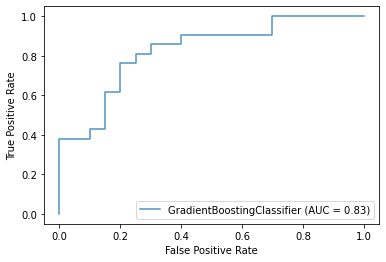

In [17]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)
ax = plt.gca()
gbc_disp = plot_roc_curve(gbc, X_test, y_test, ax=ax, alpha=0.8)
plt.savefig('../Images/gbc_ROC.png')
plt.show()

[00:52:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


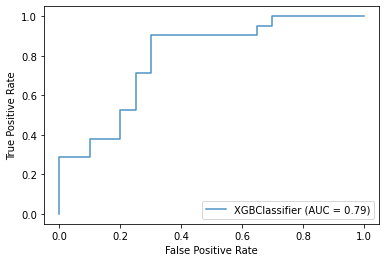

In [18]:
xgbc = XGBClassifier(random_state=42)
xgbc.fit(X_train, y_train)
ax = plt.gca()
xgbc_disp = plot_roc_curve(xgbc, X_test, y_test, ax=ax, alpha=0.8)
plt.savefig('../Images/xgbc_ROC.png')
plt.show()

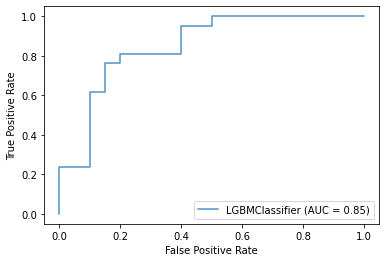

In [19]:
lgbc = LGBMClassifier(random_state=42)
lgbc.fit(X_train, y_train)
ax = plt.gca()
lgbc_disp = plot_roc_curve(lgbc, X_test, y_test, ax=ax, alpha=0.8)
plt.savefig('../Images/lgbc_ROC.png')
plt.show()

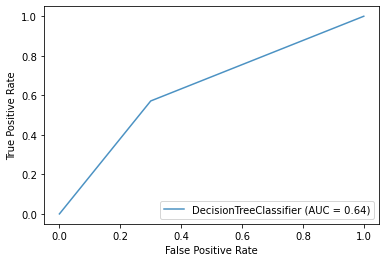

In [20]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
ax = plt.gca()
dtc_disp = plot_roc_curve(dtc, X_test, y_test, ax=ax, alpha=0.8)
plt.savefig('../Images/dtc_ROC.png')
plt.show()

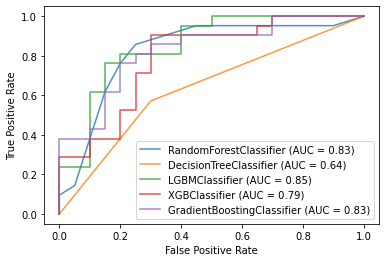

In [21]:
rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(X_train, y_train)
ax = plt.gca()
rfc_disp = plot_roc_curve(rfc, X_test, y_test, ax=ax, alpha=0.8)
dtc_disp.plot(ax=ax, alpha=0.8)
lgbc_disp.plot(ax=ax, alpha=0.8)
xgbc_disp.plot(ax=ax, alpha=0.8)
gbc_disp.plot(ax=ax, alpha=0.8)
plt.savefig('../Images/rfc_ROC.png')
plt.show()

## Let's Pick a Final Model To Move Forward With

From the above evaluations, it looks like LGBMClassifier is a very promising candidate

We will then hypertune the classifier model to come up with the best model we can.

## Let's Create Our Tuning Object

In [22]:
# RandomizedSearchCV on LGBM

lgbm_param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 300, 400],
    'max_depth': np.arange(5, 20),
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': np.arange(0.5, 1.0, 0.05),
    'min_child_weight': np.arange(1, 10),
    'colsample_bytree': np.arange(0.2, 1.0, 0.1),
    'gamma': [0, 0.001, 0.002, 0.003, 0.004, 0.005, 1e-2],
    'n_jobs': [-1]
}

# lgbm_param_grid = {
#     'learning_rate': [ 0.1],
#     'num_leaves': [31],
#     'boosting_type' : ['gbdt'],
#     'objective' : ['binary']
# }

# lgbm_param_grid = {

#         # 'bagging_fraction': (0.5, 0.8),
#         # 'bagging_frequency': (5, 8),
#         'n_jobs': [-1]
#         'feature_fraction': (0.5, 0.8),
#         'max_depth': (10, 13),
#         'min_data_in_leaf': (90, 120),
#         'num_leaves': (1200, 1550)

# }

## Let's find The Best Model We Can

The RandomizedSearchCV function will try all our combinations above and select the most accurate model.  

That best model is found in the best_estimator_ property of the RandomizedSerachCV object. 

In [23]:
predictor = LGBMClassifier()
rs = RandomizedSearchCV(predictor, lgbm_param_grid, cv=5, scoring='f1', n_jobs=-1, n_iter=100, verbose=1)
rs.fit(X_train, y_train)
evaluate(rs.best_estimator_, X_train, X_test, y_train, y_test)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
========== Predictor: LGBMClassifier ==========
Training result: f1: 0.764, acc: 0.756
Test result: f1: 0.714, acc: 0.707

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    6.0s finished


# Evaluate Our Model Further

Now we are going to shuffle the data over and over and apply our new model to the results to further determine if we want to use this model.

In [24]:
# evaluate model with kfold

kfold = KFold(n_splits=10)
results = cross_val_score(rs.best_estimator_, X, y, cv=kfold, n_jobs=-1)
print("Results: %.2f (%.2f) accuracy" % (results.mean(), results.std()))

Results: 0.65 (0.06) accuracy


## Save The Model For Future Use

In [25]:
# save model

with open(f'lgbm_model.pickle', 'wb') as f:
    pickle.dump(rs.best_estimator_, f)

## Confirm File

Make sure the operating system you are NOT using is commented out below

In [30]:
# windows
# ! dir best_xgb*
! dir lgbm_model*
# mac / linux / Unix
# ! ls -a best_xgb*

 Volume in drive C is TI10653400C
 Volume Serial Number is 24D7-5A9C

 Directory of c:\Users\tahir\Desktop\repos\are_you_hot\Project_3_Hot_Model

12/13/2020  12:09 AM            12,780 lgbm_model.pickle
               1 File(s)         12,780 bytes
               0 Dir(s)  34,847,309,824 bytes free
